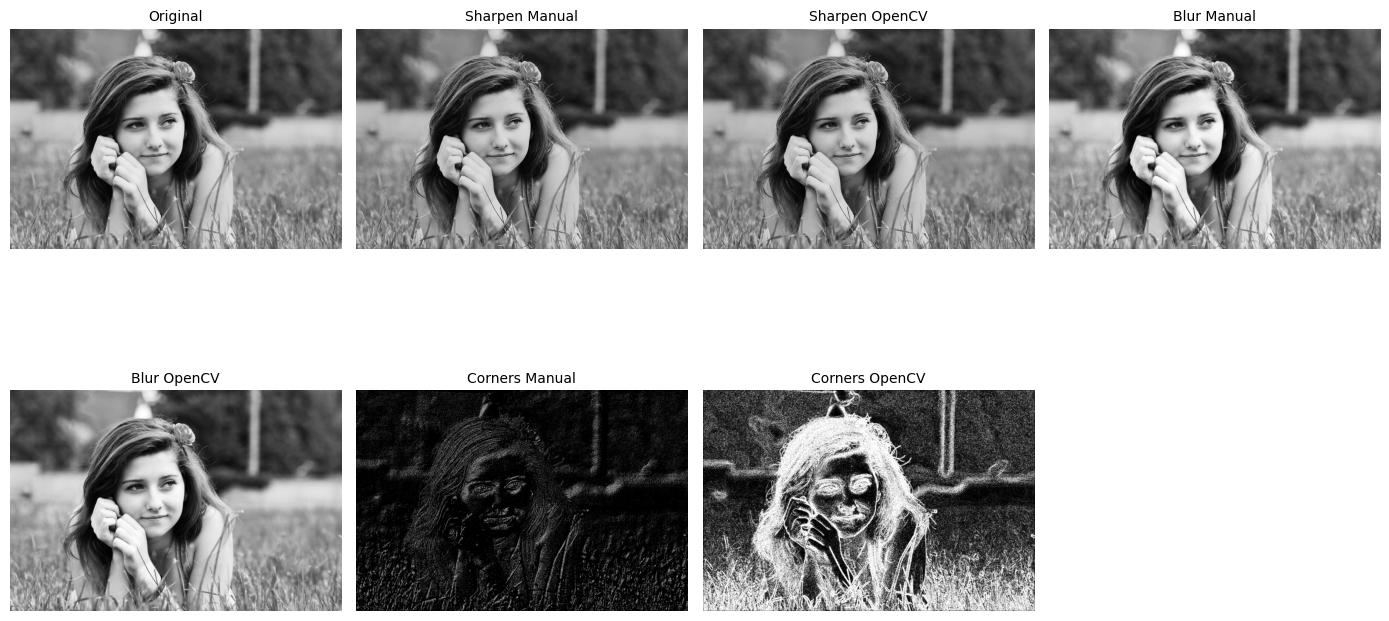

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tkinter import Tk, Scale, Label, HORIZONTAL, Frame, LEFT, BOTH, TOP, BOTTOM
from PIL import Image, ImageTk

# Load grayscale image
img = cv2.imread('imagen.jpg', cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError("Could not find 'test.jpg' in the current directory.")

# Manual 2D convolution (vectorized for performance)
def convolve2d_manual(image, kernel):
    kh, kw = kernel.shape
    pad_h, pad_w = kh // 2, kw // 2
    padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='reflect')
    windows = np.lib.stride_tricks.sliding_window_view(padded, (kh, kw))
    output = np.sum(windows * kernel, axis=(-2, -1))
    output = np.clip(output, 0, 255)
    return output.astype(np.uint8)

# Custom kernels
kernel_sharpen = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]], dtype=np.float32)

kernel_blur = np.ones((3, 3), dtype=np.float32) / 9.0

kernel_sobel_x = np.array([[-1, 0, 1],
                           [-2, 0, 2],
                           [-1, 0, 1]], dtype=np.float32)
kernel_sobel_y = np.array([[-1, -2, -1],
                           [0,  0,  0],
                           [1,  2,  1]], dtype=np.float32)

# Corner response using cross Sobel derivatives
def corner_response(image):
    gx = convolve2d_manual(image, kernel_sobel_x)
    gy = convolve2d_manual(image, kernel_sobel_y)
    response = np.abs(gx) * np.abs(gy)
    response = np.clip(response, 0, 255)
    return response.astype(np.uint8)

# Apply manual convolution
img_sharpen_manual = convolve2d_manual(img, kernel_sharpen)
img_blur_manual = convolve2d_manual(img, kernel_blur)
img_corner_manual = corner_response(img)

# Apply OpenCV filters for comparison
img_sharpen_cv = cv2.filter2D(img, -1, kernel_sharpen)
img_blur_cv = cv2.filter2D(img, -1, kernel_blur)
sobelx_cv = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
sobely_cv = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
img_corner_cv = np.abs(sobelx_cv) * np.abs(sobely_cv)
img_corner_cv = np.clip(img_corner_cv, 0, 255).astype(np.uint8)

# Show results side by side using matplotlib
titles = [
    'Original',
    'Sharpen Manual', 'Sharpen OpenCV',
    'Blur Manual', 'Blur OpenCV',
    'Corners Manual', 'Corners OpenCV'
]
images = [
    img,
    img_sharpen_manual, img_sharpen_cv,
    img_blur_manual, img_blur_cv,
    img_corner_manual, img_corner_cv
]

plt.figure(figsize=(14, 8))
for i in range(len(images)):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i], fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()

# BONUS: Interactive Tkinter interface to modify the sharpen kernel
def cv2_to_tk(img_cv2):
    """Convert OpenCV grayscale image to ImageTk.PhotoImage"""
    img_pil = Image.fromarray(img_cv2)
    return ImageTk.PhotoImage(img_pil)

# Update sharpened image dynamically with modified kernel
def update_sharpen_dynamic():
    center = sharpen_centro.get()
    sides = sharpen_lados.get()
    sides = max(1, sides)
    kernel_dynamic = np.array([[0, -sides, 0],
                               [-sides, center, -sides],
                               [0, -sides, 0]], dtype=np.float32)
    img_sharpen_dynamic = convolve2d_manual(img, kernel_dynamic)
    tk_img = cv2_to_tk(img_sharpen_dynamic)
    sharpen_dynamic_label.configure(image=tk_img)
    sharpen_dynamic_label.image = tk_img
    kernel_label.config(text=f"Kernel:\n{kernel_dynamic}")

# Debounce to avoid excessive updates and reduce lag
after_id = None
def on_sharpen_slider_change(event=None):
    global after_id
    if after_id is not None:
        root.after_cancel(after_id)
    after_id = root.after(50, update_sharpen_dynamic)

# Tkinter interactive interface setup
root = Tk()
root.title("Interactive Sharpen (Tkinter)")

inter_frame = Frame(root, bd=2, relief="groove")
inter_frame.pack(side=TOP, fill=BOTH, expand=False, pady=10, padx=10)

Label(inter_frame, text="Interactive Sharpen (Tkinter)", font=("Arial", 12, "bold")).pack(side=TOP, pady=5)

slider_frame = Frame(inter_frame)
slider_frame.pack(side=LEFT, padx=10)
sharpen_centro = Scale(slider_frame, from_=1, to=10, orient=HORIZONTAL, label="Center", command=on_sharpen_slider_change)
sharpen_centro.set(5)
sharpen_centro.pack()
sharpen_lados = Scale(slider_frame, from_=1, to=10, orient=HORIZONTAL, label="Sides", command=on_sharpen_slider_change)
sharpen_lados.set(1)
sharpen_lados.pack()

img_sharpen_dynamic = convolve2d_manual(img, kernel_sharpen)
tk_img_dynamic = cv2_to_tk(img_sharpen_dynamic)
sharpen_dynamic_label = Label(inter_frame, image=tk_img_dynamic)
sharpen_dynamic_label.image = tk_img_dynamic
sharpen_dynamic_label.pack(side=LEFT, padx=10)

kernel_label = Label(inter_frame, text="Kernel:\n[[0, -1, 0],\n [-1, 5, -1],\n [0, -1, 0]]", font=("Courier", 10))
kernel_label.pack(side=LEFT, padx=10)

root.mainloop()
